In [1]:
# IMPORTS & HELPERS
# We import libraries and explain why each is used so participants understand dependencies.
import random               # for random actions and exploration
import math                 # math helpers (not heavily used but handy)
import numpy as np          # numerical arrays and math functions
import pandas as pd         # DataFrame for dataset handling
import matplotlib.pyplot as plt  # plotting for comparisons

# Fix seeds so it is reproducible.
RSEED = 42
random.seed(RSEED)
np.random.seed(RSEED)

# Simple format helper to display money-like numbers cleanly.
def money(x):
    # Round to nearest dollar and format with $ sign (human-friendly)
    return f"${x:.0f}"

# Pretty-print a single simulation step in a fully labelled way.
def pretty_print_step(step_idx, state, action, reward, next_state):
    # Map action integer to descriptive label
    action_map = {0: 'No Discount (0%)', 1: '10% Discount', 2: '20% Discount'}
    action_label = action_map.get(action, str(action))
    # show + sign for positive rewards for readability
    sign = '+' if reward >= 0 else ''
    print(f"Step {step_idx} | State=(stock={state[0]}, demand={state[1]}) | Action={action} -> {action_label} | Reward={sign}{money(reward)} | Next=(stock={next_state[0]}, demand={next_state[1]})")

##Dataset (200 days)

We create a small dataset to simulate demand and stock availability. The dataset is deterministic once the seed is fixed.
Columns:
- `day`: day index (1..200)
- `demand_base`: Poisson(3) draws representing base demand
- `stock_available`: random inventory between 0 and 5
- `demand`: demand capped at 5 (keeps state-space small for teaching)


In [2]:
# DATASET CREATION
# Number of days in the simulated log
days = 200

# We cap stock and demand to 5 to keep the discrete state-space small and easy to reason about.
MAX_STOCK = 5

# Generate baseline demand using a Poisson distribution with lambda=3 (common simple model for count data)
demand_base = np.random.poisson(3, days)

# Generate an available stock for each day uniformly between 0 and MAX_STOCK
stock_available = np.random.randint(0, MAX_STOCK+1, days)

# Cap the demand to MAX_STOCK to ensure state (stock,demand) lives in a small grid
demand = np.clip(demand_base, 0, MAX_STOCK)

# Create the DataFrame with our columns
df = pd.DataFrame({
    'day': np.arange(1, days+1),       # 1..days
    'demand_base': demand_base,        # raw Poisson draws
    'stock_available': stock_available,# available inventory
    'demand': demand                   # capped demand used by env
})

# Show first rows so participants can inspect sample data
df.head(8)

,day,demand_base,stock_available,demand
0,1,4,4,4
1,2,1,4,1
2,3,3,4,3
3,4,3,3,3
4,5,2,3,2
5,6,3,4,3
6,7,2,1,2
7,8,3,2,3


## MDP Setup

Here we define the MDP in full detail. We show the reward formula, map each symbol to dataset columns, and implement the step function.

### Concepts & formula
- State s = (stock_available, demand)
- Action a ∈ {0,1,2} meaning {0%, 10%, 20%} discount
- Reward (per day):

\( R = p \times sales - c \times a - penalty \times missed \)

In our demo we set: p=100, c=20, penalty=20

### Mapping to dataset
| Symbol | Dataset column |
|---|---|
| s | (stock_available, demand) |
| a | action (0/1/2) |
| sales | min(stock_available, boosted_demand) |
| boosted_demand | df['demand'][day_idx] + a |
| R | computed profit using the formula above |

Now the `model_step` (deterministic) and `env_step` (time-indexed) functions follow with line-by-line comments.


In [4]:
# MDP constants
PRICE_PER_SALE = 100                # revenue per unit sold
DISCOUNT_COST_PER_LEVEL = 20        # dollar cost per discount level (10% -> 1 -> $20)
STOCKOUT_PENALTY_PER_MISSED = 20    # penalty for each missed unit of demand
DEMAND_CAP = MAX_STOCK              # consistent cap

# All discrete states for clarity (used only for enumerations like value iteration)
states = [(s,d) for s in range(MAX_STOCK+1) for d in range(MAX_STOCK+1)]

# Actions available to agent
actions = [0,1,2]  # 0 = no discount, 1 = 10%, 2 = 20%

# Deterministic step used for Value Iteration (stable backups)
def model_step(current_state, action):
    # Unpack the state tuple into meaningful variable names
    stock, demand = current_state  # stock: units in warehouse, demand: customer's base demand

    # Discount action increases demand by action units
    boosted_demand = min(DEMAND_CAP, demand + action)  # cap so we don't explode demand

    # Sales are the min of what customers want and what we can supply
    sales = min(stock, boosted_demand)

    # After sales, compute remaining inventory
    new_stock = max(0, stock - sales)

    # Reward components: revenue, discount cost, stockout penalty
    revenue = PRICE_PER_SALE * sales
    discount_cost = DISCOUNT_COST_PER_LEVEL * action
    missed = max(0, boosted_demand - stock)  # units of unmet demand
    stockout_penalty = -STOCKOUT_PENALTY_PER_MISSED * missed

    # Total reward (what RL observes)
    reward = revenue - discount_cost + stockout_penalty

    # Deterministic next demand model for value iteration: keep demand same for clarity
    next_state = (new_stock, demand)
    return next_state, reward

# env_step uses the dataset (df) to get realistic day-by-day demand and is used for simulations
def env_step(current_state, action, df, day_idx):
    # Use df to get today's demand (modulo wraps if simulation longer than dataset)
    base_demand = int(df.loc[day_idx % len(df), 'demand'])

    # Discount increases observed demand
    boosted_demand = min(DEMAND_CAP, base_demand + action)

    # Sales limited by stock
    stock = current_state[0]
    sales = min(stock, boosted_demand)

    # Inventory after sales
    new_stock = max(0, stock - sales)

    # Reward decomposition
    revenue = PRICE_PER_SALE * sales
    discount_cost = DISCOUNT_COST_PER_LEVEL * action
    missed = max(0, boosted_demand - stock)
    stockout_penalty = -STOCKOUT_PENALTY_PER_MISSED * missed
    reward = revenue - discount_cost + stockout_penalty

    # Next demand is taken from dataset to simulate time evolution
    next_demand = int(df.loc[(day_idx + 1) % len(df), 'demand'])
    next_demand = min(DEMAND_CAP, max(0, next_demand))

    next_state = (new_stock, next_demand)
    return next_state, reward

# Quick test run for 5 random steps with line-by-line prints to show dynamics
print('--- Quick MDP sanity run (5 random steps) ---')
state = (3,2)  # starting from 3 units in stock and demand 2
total_reward = 0
for step_idx in range(5):
    # pick a random discount action for demonstration
    action = random.choice(actions)
    # step through env_step to use dataset-driven demand
    next_state, reward = env_step(state, action, df, step_idx)
    # print a labeled line for participants to read
    pretty_print_step(step_idx, state, action, reward, next_state)
    total_reward += reward
    state = next_state

print('Total reward over 5 demo steps (random actions):', money(total_reward))

--- Quick MDP sanity run (5 random steps) ---
Step 0 | State=(stock=3, demand=2) | Action=2 -> 20% Discount | Reward=+$220 | Next=(stock=0, demand=1)
Step 1 | State=(stock=0, demand=1) | Action=0 -> No Discount (0%) | Reward=$-20 | Next=(stock=0, demand=3)
Step 2 | State=(stock=0, demand=3) | Action=0 -> No Discount (0%) | Reward=$-60 | Next=(stock=0, demand=3)
Step 3 | State=(stock=0, demand=3) | Action=2 -> 20% Discount | Reward=$-140 | Next=(stock=0, demand=2)
Step 4 | State=(stock=0, demand=2) | Action=1 -> 10% Discount | Reward=$-80 | Next=(stock=0, demand=3)
Total reward over 5 demo steps (random actions): $-80


##Discounted Rewards (G)

Formula:
\( G_t = R_t + \gamma R_{t+1} + \gamma^2 R_{t+2} + \dots \)

We use γ=0.9 in the demo. Example substitution will be printed step-by-step.


In [5]:
# Discounted returns example (detailed prints)
GAMMA = 0.9  # how much future rewards matter relative to immediate reward
start_state = (3,2)
state = start_state
discounted_total = 0.0

print('--- Discounted reward breakdown for a short episode ---')
for t in range(6):
    action = random.choice(actions)  # random policy for demonstration
    next_state, reward = env_step(state, action, df, t)
    # contribution of this reward to G_0
    contrib = (GAMMA ** t) * reward
    print(f"t={t} | state={state} | action={action} | reward={money(reward)} | gamma^{t}={GAMMA**t:.3f} | contribution={money(contrib)} | next={next_state}")
    discounted_total += contrib
    state = next_state

print('\nG_0 (total discounted return) for this demo episode =', money(discounted_total))

--- Discounted reward breakdown for a short episode ---
t=0 | state=(3, 2) | action=0 | reward=$280 | gamma^0=1.000 | contribution=$280 | next=(0, 1)
t=1 | state=(0, 1) | action=0 | reward=$-20 | gamma^1=0.900 | contribution=$-18 | next=(0, 3)
t=2 | state=(0, 3) | action=0 | reward=$-60 | gamma^2=0.810 | contribution=$-49 | next=(0, 3)
t=3 | state=(0, 3) | action=2 | reward=$-140 | gamma^3=0.729 | contribution=$-102 | next=(0, 2)
t=4 | state=(0, 2) | action=0 | reward=$-40 | gamma^4=0.656 | contribution=$-26 | next=(0, 3)
t=5 | state=(0, 3) | action=2 | reward=$-140 | gamma^5=0.590 | contribution=$-83 | next=(0, 2)

G_0 (total discounted return) for this demo episode = $2


## Value Iteration (Bellman Optimality)

Bellman Optimality Equation (V):
\( V(s) = \max_a [ R(s,a) + \gamma \sum_{s'} P(s'|s,a) V(s') ] \)

Because our `model_step` is deterministic for teaching, the sum over s' disappears:
\( V(s) = \max_a [ R(s,a) + \gamma V(s') ] \)

We will run synchronous value iteration and then show the greedy policy at a sample state.


In [6]:
# Value Iteration implementation with clear comments and printing
GAMMA = 0.9

# Initialize V(s) = 0 for all discrete states (stock in 0..MAX_STOCK, demand in 0..MAX_STOCK)
V = {(s,d): 0.0 for s in range(MAX_STOCK+1) for d in range(MAX_STOCK+1)}

NUM_ITERS = 80  # number of sweeps through the state-space
for it in range(NUM_ITERS):
    newV = V.copy()  # synchronous update: compute newV from old V
    # iterate through all possible states
    for stock in range(MAX_STOCK+1):
        for demand in range(MAX_STOCK+1):
            state = (stock, demand)
            # compute value for each action: r + gamma * V[next_state]
            action_vals = []
            for a in actions:
                next_state, r = model_step(state, a)  # deterministic, uses state's demand
                val = r + GAMMA * V[next_state]        # immediate + discounted future
                action_vals.append(val)
            # Bellman update: pick best action value
            newV[state] = max(action_vals)
    V = newV

# Show example value and derive greedy policy
print('Example: V(3,2) =', money(V[(3,2)]))

# Build greedy policy: choose argmax_a r + gamma * V[next_state]
policy_from_V = {}
for stock in range(MAX_STOCK+1):
    for demand in range(MAX_STOCK+1):
        state = (stock, demand)
        best_a = None
        best_val = -1e12
        for a in actions:
            nxt, r = model_step(state, a)
            val = r + GAMMA * V[nxt]
            if val > best_val:
                best_val = val
                best_a = a
        policy_from_V[state] = best_a

print('Greedy action from Value Iteration for (3,2):', policy_from_V[(3,2)])

Example: V(3,2) = $-52
Greedy action from Value Iteration for (3,2): 0


##Q-Learning (Model-free)

Q-Learning update rule (off-policy bootstrapping):

\( Q(s,a) \leftarrow Q(s,a) + \alpha [ R + \gamma \max_{a'} Q(s',a') - Q(s,a) ] \)

Mapping to dataset columns:
- s = (stock_available, demand) using df row to initialize episodes
- R = reward from env_step
- s' = next state from env_step
- We will run many episodes and then show a labeled rollout using the greedy policy derived from Q.


In [7]:
# Q-Learning implementation with line-by-line commentary
ALPHA = 0.1   # learning rate: how fast Q-values incorporate new info
GAMMA = 0.9   # discount factor
EPS = 0.1     # epsilon for exploration in epsilon-greedy

# Initialize Q-table with zeros for all state-action pairs
Q = np.zeros((MAX_STOCK+1, MAX_STOCK+1, len(actions)))

EPISODES = 2000  # number of learning episodes for demo
for ep in range(EPISODES):
    # initialize episode start from dataset row day_idx to give diverse starts
    day_idx = ep % len(df)
    start_stock = int(df.loc[day_idx, 'stock_available'])
    start_demand = int(df.loc[day_idx, 'demand'])
    state = (start_stock, start_demand)

    # Epsilon-greedy action selection: explore with probability EPS
    if random.random() < EPS:
        action = random.choice(actions)
    else:
        action = int(np.argmax(Q[state[0], state[1]]))

    # Take action in environment and observe next state and reward
    next_state, reward = env_step(state, action, df, day_idx)

    # Q-learning target uses max over next state's actions (off-policy)
    best_next = np.max(Q[next_state[0], next_state[1]])

    # Q update: move current Q(state,action) toward target
    Q[state[0], state[1], action] += ALPHA * (reward + GAMMA * best_next - Q[state[0], state[1], action])

# Print example Q-values for a state to illustrate learned estimates
print('Q-values for state (3,2):', Q[3,2])

# Derive greedy policy from Q for rollout demonstration
policy_from_Q = {(s,d): int(np.argmax(Q[s,d])) for s in range(MAX_STOCK+1) for d in range(MAX_STOCK+1)}

# Labeled rollout under the learned greedy policy (demonstration)
print('\nLabeled rollout under Q-greedy policy:') 
state = (3,2)
for t in range(8):
    a = policy_from_Q[state]
    nxt, r = env_step(state, a, df, t)
    pretty_print_step(t, state, a, r, nxt)
    state = nxt

Q-values for state (3,2): [185.93898666  76.12731561  42.82674217]

Labeled rollout under Q-greedy policy:
Step 0 | State=(stock=3, demand=2) | Action=0 -> No Discount (0%) | Reward=+$280 | Next=(stock=0, demand=1)
Step 1 | State=(stock=0, demand=1) | Action=2 -> 20% Discount | Reward=$-100 | Next=(stock=0, demand=3)
Step 2 | State=(stock=0, demand=3) | Action=0 -> No Discount (0%) | Reward=$-60 | Next=(stock=0, demand=3)
Step 3 | State=(stock=0, demand=3) | Action=0 -> No Discount (0%) | Reward=$-60 | Next=(stock=0, demand=2)
Step 4 | State=(stock=0, demand=2) | Action=0 -> No Discount (0%) | Reward=$-40 | Next=(stock=0, demand=3)
Step 5 | State=(stock=0, demand=3) | Action=0 -> No Discount (0%) | Reward=$-60 | Next=(stock=0, demand=2)
Step 6 | State=(stock=0, demand=2) | Action=0 -> No Discount (0%) | Reward=$-40 | Next=(stock=0, demand=3)
Step 7 | State=(stock=0, demand=3) | Action=0 -> No Discount (0%) | Reward=$-60 | Next=(stock=0, demand=0)


##SARSA (On-policy)

SARSA update rule (on-policy):

\( Q(s,a) \leftarrow Q(s,a) + \alpha [ R + \gamma Q(s',a') - Q(s,a) ] \)

SARSA uses the actual next action a' taken by the policy (on-policy), which makes it more conservative in risky environments.


In [8]:
# SARSA implementation with comments
ALPHA = 0.1
GAMMA = 0.9
EPS = 0.1

Q_sarsa = np.zeros((MAX_STOCK+1, MAX_STOCK+1, len(actions)))

EPISODES = 2000
for ep in range(EPISODES):
    day_idx = ep % len(df)
    state = (int(df.loc[day_idx, 'stock_available']), int(df.loc[day_idx, 'demand']))

    # initial action (epsilon-greedy)
    if random.random() < EPS:
        action = random.choice(actions)
    else:
        action = int(np.argmax(Q_sarsa[state[0], state[1]]))

    # execute action
    next_state, reward = env_step(state, action, df, day_idx)

    # pick next action according to current policy (epsilon-greedy)
    if random.random() < EPS:
        next_action = random.choice(actions)
    else:
        next_action = int(np.argmax(Q_sarsa[next_state[0], next_state[1]]))

    # SARSA update uses Q[next_state, next_action] not max_a' Q
    Q_sarsa[state[0], state[1], action] += ALPHA * (reward + GAMMA * Q_sarsa[next_state[0], next_state[1], next_action] - Q_sarsa[state[0], state[1], action])

# Example output and labeled rollout
print('SARSA Q for (3,2):', Q_sarsa[3,2])
policy_from_sarsa = {(s,d): int(np.argmax(Q_sarsa[s,d])) for s in range(MAX_STOCK+1) for d in range(MAX_STOCK+1)}

print('\nLabeled rollout under SARSA-greedy policy:')
st = (3,2)
for t in range(8):
    a = policy_from_sarsa[st]
    nxt, r = env_step(st, a, df, t)
    pretty_print_step(t, st, a, r, nxt)
    st = nxt

SARSA Q for (3,2): [182.52928751  56.29449256  67.57419234]

Labeled rollout under SARSA-greedy policy:
Step 0 | State=(stock=3, demand=2) | Action=0 -> No Discount (0%) | Reward=+$280 | Next=(stock=0, demand=1)
Step 1 | State=(stock=0, demand=1) | Action=0 -> No Discount (0%) | Reward=$-20 | Next=(stock=0, demand=3)
Step 2 | State=(stock=0, demand=3) | Action=0 -> No Discount (0%) | Reward=$-60 | Next=(stock=0, demand=3)
Step 3 | State=(stock=0, demand=3) | Action=0 -> No Discount (0%) | Reward=$-60 | Next=(stock=0, demand=2)
Step 4 | State=(stock=0, demand=2) | Action=1 -> 10% Discount | Reward=$-80 | Next=(stock=0, demand=3)
Step 5 | State=(stock=0, demand=3) | Action=0 -> No Discount (0%) | Reward=$-60 | Next=(stock=0, demand=2)
Step 6 | State=(stock=0, demand=2) | Action=1 -> 10% Discount | Reward=$-80 | Next=(stock=0, demand=3)
Step 7 | State=(stock=0, demand=3) | Action=0 -> No Discount (0%) | Reward=$-60 | Next=(stock=0, demand=0)


##Monte Carlo (First-visit / Episode averaging)

Monte Carlo evaluates a policy by averaging full-episode returns (no bootstrapping). We evaluate 'always 10%' and Q-greedy policies.


In [9]:
# Monte Carlo evaluation function (averages returns over episodes)
def monte_carlo_eval(policy_fn, episodes=300, horizon=5, gamma=0.9):
    returns = []
    for ep in range(episodes):
        state = (3,2)  # fixed start to compare policies consistently
        G = 0.0
        for t in range(horizon):
            a = policy_fn(state)
            state, r = env_step(state, a, df, ep + t)  # use time index for realism
            G += (gamma ** t) * r
        returns.append(G)
    return np.mean(returns), returns

always_10 = lambda s: 1
mc_always_mean, _ = monte_carlo_eval(always_10, episodes=200)
mc_q_mean, _ = monte_carlo_eval(lambda s: policy_from_Q[s], episodes=200)
print('Monte Carlo mean return (always 10%):', money(mc_always_mean))
print('Monte Carlo mean return (Q-greedy):', money(mc_q_mean))

Monte Carlo mean return (always 10%): $-16
Monte Carlo mean return (Q-greedy): $52


##Monte Carlo Tree Search (Toy UCT planner)

MCTS runs many random rollouts from the current state, building a search tree and using UCB for selection. It's a planning method (not learning) and useful for short-horizon decisions.


In [10]:
# Simple MCTS node and planner for demonstration
class MCTSNode:
    def __init__(self, state, parent=None, action=None):
        self.state = state
        self.parent = parent
        self.action = action
        self.children = []
        self.visits = 0
        self.value = 0.0

    def ucb(self, c=1.4):
        # If never visited, encourage exploration
        if self.visits == 0:
            return float('inf')
        if self.parent is None or self.parent.visits == 0:
            return self.value / self.visits
        return (self.value / self.visits) + c * np.sqrt(np.log(self.parent.visits) / self.visits)

def mcts_planner(root_state, df, sims=400, rollout_depth=4):
    root = MCTSNode(root_state)
    for _ in range(sims):
        node = root
        # Selection: follow highest UCB until leaf
        while node.children:
            node = max(node.children, key=lambda c: c.ucb())
        # Expansion: add children (all actions) if expandable
        if node.state[0] > 0:  # only if there's stock to act upon
            for a in actions:
                nxt, _ = model_step(node.state, a)
                node.children.append(MCTSNode(nxt, node, a))
            node = random.choice(node.children)
        # Simulation: random rollout for a few steps
        sim_state = node.state
        sim_reward = 0.0
        for d in range(rollout_depth):
            a = random.choice(actions)
            sim_state, r = model_step(sim_state, a)  # model_step: deterministic short rollout
            sim_reward += r
        # Backpropagation
        while node is not None:
            node.visits += 1
            node.value += sim_reward
            node = node.parent
    # Choose best child by visits
    if not root.children:
        return 0, 0.0
    best = max(root.children, key=lambda c: c.visits)
    return best.action, best.value / best.visits

# Run MCTS planner example from (3,2)
action_suggested, expected_val = mcts_planner((3,2), df, sims=500, rollout_depth=4)
print('MCTS suggests action:', action_suggested, '->', {0:'No',1:'10%',2:'20%'}[action_suggested], 'expected approx', money(expected_val))

MCTS suggests action: 1 -> 10% expected approx $-320


##Comparison & Visualization

Run rollouts for each policy (Random, ValueIter greedy, Q-greedy, SARSA-greedy, MC) and compare via boxplot and medians.


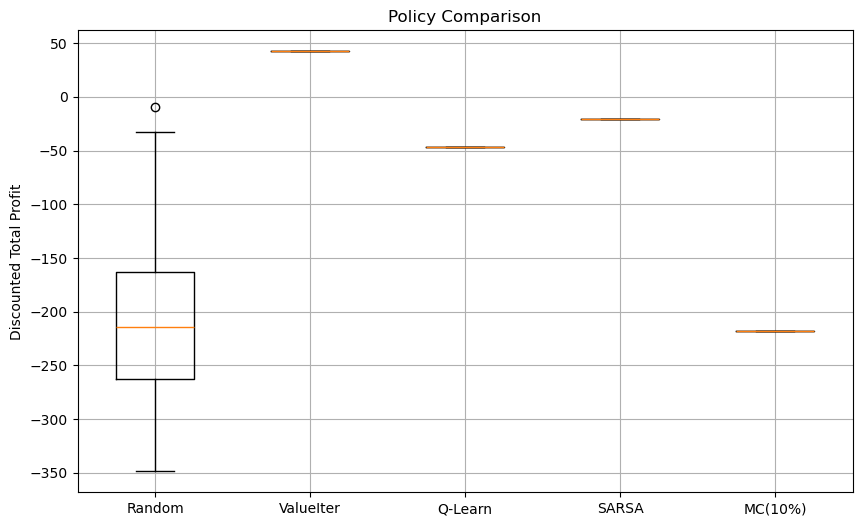

Median Results:
Random: $-214
ValueIter: $43
Q-Learn: $-47
SARSA: $-20
MC(10%): $-218


In [11]:
# Helper to rollout a policy and compute discounted total
def rollout_with_policy(policy_fn, start=(3,2), days=10, gamma=0.9):
    s = start
    total = 0.0
    for t in range(days):
        a = policy_fn(s)
        s, r = env_step(s, a, df, t)
        total += (gamma ** t) * r
    return total

# define policies
random_policy = lambda s: random.choice(actions)
value_policy = lambda s: policy_from_V[s]
q_policy = lambda s: policy_from_Q[s]
sarsa_policy = lambda s: policy_from_sarsa[s]
mc_policy = lambda s: 1  # always 10%

# Collect rollouts
N = 60
rand_rolls = [rollout_with_policy(random_policy, start=(3,2)) for _ in range(N)]
val_rolls = [rollout_with_policy(value_policy, start=(3,2)) for _ in range(N)]
q_rolls = [rollout_with_policy(q_policy, start=(3,2)) for _ in range(N)]
sarsa_rolls = [rollout_with_policy(sarsa_policy, start=(3,2)) for _ in range(N)]
mc_rolls = [rollout_with_policy(mc_policy, start=(3,2)) for _ in range(N)]

# Plot boxplot
plt.figure(figsize=(10,6))
plt.boxplot([rand_rolls, val_rolls, q_rolls, sarsa_rolls, mc_rolls], labels=['Random','ValueIter','Q-Learn','SARSA','MC(10%)'])
plt.ylabel('Discounted Total Profit'); plt.title('Policy Comparison'); plt.grid(True); plt.show()

# Print medians
import numpy as np
print('Median Results:')
print('Random:', money(np.median(rand_rolls)))
print('ValueIter:', money(np.median(val_rolls)))
print('Q-Learn:', money(np.median(q_rolls)))
print('SARSA:', money(np.median(sarsa_rolls)))
print('MC(10%):', money(np.median(mc_rolls)))